In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Load data ###

In [2]:
def read_off(filename):
    """
    Reads an OFF or NOFF file of oriented points.

    Parameters:
    - filename (str): Path to the OFF/NOFF file.

    Returns:
    - points (np.ndarray): Array of points (vertices) with shape (n, 3).
    - normals (np.ndarray or None): Array of normals with shape (n, 3), or None if not present.
    """
    X = []
    N = []

    with open(filename, 'r') as infile:
        # Read and parse the header
        header = infile.readline().strip()
        if header not in {"OFF", "NOFF"}:
            raise ValueError(f"Invalid OFF file header: {header}")
        
        # Read the second line (number of vertices, faces, edges)
        info = infile.readline().strip()
        nvertices, nfaces, nedges = map(int, info.split())
        
        # Read the vertices (and optionally normals if NOFF)
        for _ in range(nvertices):
            line = infile.readline().strip()
            values = list(map(float, line.split()))
            
            x, y, z = values[:3]
            X.append([x, y, z])
            
            if header == "NOFF" and len(values) >= 6:  # If NOFF, normals are included
                nx, ny, nz = values[3:6]
                N.append([nx, ny, nz])
    
    # Convert lists to numpy arrays
    X = np.array(X)
    N = np.array(N) if N else None

    return X, N


In [3]:
data = read_off("cat.off")
X, N = data[0], data[1]


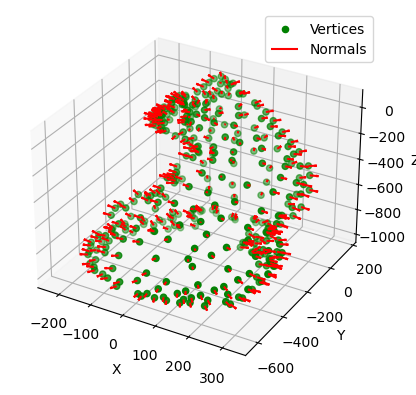

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot vertices
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='g', label="Vertices", s=20)  # s controls marker size

# Plot normals using quiver
ax.quiver(X[:, 0], X[:, 1], X[:, 2],  # Starting points of arrows
          N[:, 0], N[:, 1], N[:, 2],  # Directions of arrows (normals)
          length=25, normalize=True, color='r', label="Normals")  # Adjust length as needed

# Add legend
ax.legend()

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


### Define Tessellation ###

In [98]:
def compute_bounding_box(X):
    min_x = np.min(X[:,0])
    max_x = np.max(X[:,0])
    min_y = np.min(X[:,1])
    max_y = np.max(X[:,1])
    min_z = np.min(X[:, 2])
    max_z = np.max(X[:, 2])
    return min_x, max_x, min_y, max_y, min_z, max_z

def compute_grid(X, min_x, max_x, min_y, max_y, min_z, max_z, cell_size=0.1, padding=0.2):
    x = np.linspace(min_x - padding, max_x + padding, int((max_x - min_x + 2 * padding) / cell_size))
    y = np.linspace(min_y - padding, max_y + padding, int((max_y - min_y + 2 * padding) / cell_size))
    z = np.linspace(min_z - padding, max_z + padding, int((max_z - min_z + 2 * padding) / cell_size))
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # 'ij' indexing for proper order
    return X, Y, Z

In [100]:
bounding_box = compute_bounding_box(X)
regular_grid = compute_grid(X, *bounding_box, cell_size=200, padding=200)
points = np.array([regular_grid[0].ravel(), regular_grid[1].ravel(), regular_grid[2].ravel()]).T
print(f'Num of points: {points.shape}')
print(points[0])

Num of points: (168, 3)
[ -427.  -837. -1190.]


Num of simplices: (667, 4)


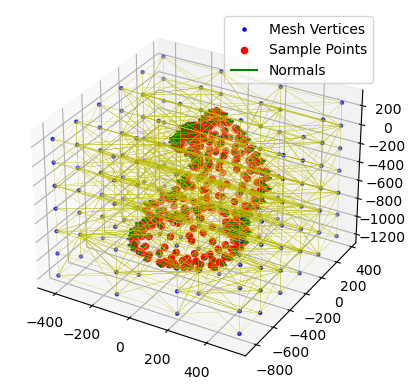

In [110]:
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d.art3d import Line3DCollection
tessellation = Delaunay(points)
print(f'Num of simplices: {tessellation.simplices.shape}')

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', s=5, label="Mesh Vertices")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color='r', s=20, label="Sample Points")

# Plot normals
ax.quiver(X[:, 0], X[:, 1], X[:, 2], 
        N[:, 0], N[:, 1], N[:, 2], 
        length=25, normalize=True, color='g', label="Normals")

# Plot Delaunay tessellation edges
edges = []
for simplex in tessellation.simplices:
    for i in range(4):  # Tetrahedra have 4 vertices
        for j in range(i + 1, 4):  # Connect each pair of vertices
            edge = [simplex[i], simplex[j]]
            edges.append(points[edge])

# Create Line3DCollection from edges
edges = np.array(edges)
edge_collection = Line3DCollection(edges, colors='y', linewidths=0.1)
ax.add_collection3d(edge_collection)

ax.legend()
plt.show()


### Compute V ###

In [111]:
def compute_gradient_per_vertex(points, X, N, sigma=50.0):
    V = np.zeros((len(points), 3))
    for i in range(len(points)):
        for j in range(len(X)):
            weight = (np.exp(-np.linalg.norm(points[i] - X[j])**2 / (2 * np.pi * sigma**2)))
            V[i] += weight * N[j]
    return V

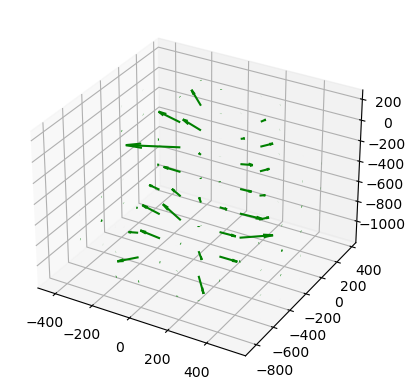

In [112]:
# Visualize V for each vertex
V_vertex = compute_gradient_per_vertex(points, X, N, sigma=50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(points[:,0], points[:,1], points[:,2], 
            V_vertex[:,0], V_vertex[:,1], V_vertex[:,2], 
            length=15, normalize=False, color='g', label="Normals")
plt.show()

In [113]:
def compute_gradient_per_face(triangulation, V):
    F = np.zeros((len(triangulation.simplices), 3))
    for i, t in enumerate(triangulation.simplices):
        # Get the indices of the vertices of the triangle
        v0, v1, v2, v3 = t

        # Get the vertex gradients
        grad0 = V[v0]
        grad1 = V[v1]
        grad2 = V[v2]
        grad3 = V[v3]

        # Compute the barycentric interpolation (uniform averaging)
        face_gradient = (grad0 + grad1 + grad2 + grad3) / 4.0

        # Store the face gradient
        F[i] = face_gradient
    return F

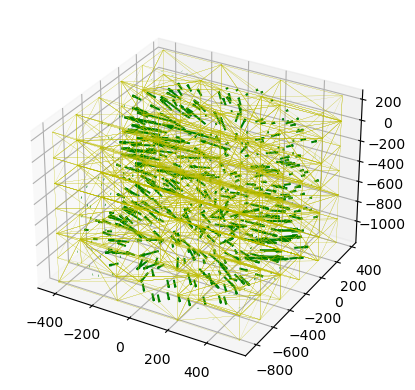

In [114]:
# Visualize V for each face
V_face = compute_gradient_per_face(tessellation, V_vertex)
centroids = np.mean(points[tessellation.simplices], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
edge_collection = Line3DCollection(edges, colors='y', linewidths=0.1)
ax.add_collection3d(edge_collection)
ax.quiver(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
        V_face[:, 0], V_face[:, 1], V_face[:, 2], 
        length=25, normalize=False, color='g', label="Normals")
plt.show()

### Solve Poisson Equation ###

In [115]:
from gpytoolbox import grad, cotangent_laplacian
import scipy.sparse as sp

In [116]:
# Compute the volume of each tetrahedron using the determinant method
def compute_tetrahedron_volume(v0, v1, v2, v3):
    matrix = np.column_stack((v1 - v0, v2 - v0, v3 - v0))
    det = np.linalg.det(matrix)
    volume = abs(det) / 6.0
    return volume

In [121]:
# Compute the simplex-wise mass matrix for a 3D tetrahedral mesh.
def compute_mass_matrix(points, simplices):
    # Extract vertex positions for each simplex
    v0, v1, v2, v3 = points[simplices[:, 0]], points[simplices[:, 1]], points[simplices[:, 2]], points[simplices[:, 3]]

    # Compute volumes for all tetrahedra
    volumes = np.array([compute_tetrahedron_volume(v0[i], v1[i], v2[i], v3[i]) for i in range(len(simplices))])

    print(f'Volumes: {volumes.shape}')
    print(f"Number of degenerate tetrahedra: {np.sum(volumes <= 1e-12)}")
    
    # Create the diagonal mass matrix
    mass_matrix = np.diag(volumes)

    return mass_matrix

M = compute_mass_matrix(points, tessellation.simplices)
M.shape


Volumes: (667,)
Number of degenerate tetrahedra: 127


(667, 667)

In [118]:
def grad_tetrahedron(V, T):
    """
    Compute the numerical gradient operator for tetrahedral meshes.

    Parameters:
    V : ndarray
        (#vertices x 3) array of vertex positions.
    T : ndarray
        (#tets x 4) array of tetrahedron indices.

    Returns:    
    G : csr_matrix
        (#tets*3 x #vertices) sparse gradient operator.
    """
    # Number of vertices and tetrahedra
    n = V.shape[0]
    m = T.shape[0]

    # Get all tetrahedron faces
    F = np.vstack([
        T[:, [0, 1, 2]],
        T[:, [0, 2, 3]],
        T[:, [0, 3, 1]],
        T[:, [1, 3, 2]]
    ])
    
    # Compute face areas
    v1 = V[F[:, 1], :] - V[F[:, 0], :]
    v2 = V[F[:, 2], :] - V[F[:, 0], :]
    face_normals = np.cross(v1, v2)
    face_areas = np.linalg.norm(face_normals, axis=1) / 2
    normalized_normals = face_normals / np.expand_dims(np.linalg.norm(face_normals, axis=1), axis=1)
    
    # Compute volumes of tetrahedra
    v21 = V[T[:, 1], :] - V[T[:, 0], :]
    v31 = V[T[:, 2], :] - V[T[:, 0], :]
    v41 = V[T[:, 3], :] - V[T[:, 0], :]
    vol = np.abs(np.einsum('ij,ij->i', v21, np.cross(v31, v41))) / 6
    
    
    print(f'F: {F.shape}')
    print(f'Face areas: {face_areas.shape}')
    print(f'Normalized normals: {normalized_normals.shape}')
    
    # Prepare indices and values for the sparse gradient matrix
    row_indices = np.concatenate([
        np.arange(m), np.arange(m), np.arange(m), np.arange(m)
    ])
    row_indices = np.tile(row_indices, 3)

    col_indices = np.tile(
        np.concatenate([T[:, 3], T[:, 1], T[:, 2], T[:, 0]]),
        3
    )

    face_areas_repeated = np.tile(face_areas / (3 * np.repeat(vol, 4)), 3)
    normal_values = normalized_normals.flatten() * face_areas_repeated

    # Assemble sparse matrix
    G = sp.csr_matrix((normal_values, (row_indices, col_indices)), shape=(3 * m, n))
    return G
    
    
G = grad_tetrahedron(points, tessellation.simplices)
print(f'G: {G.shape}')

F: (2668, 3)
Face areas: (2668,)
Normalized normals: (2668, 3)
G: (2001, 168)


/var/folders/n9/b10txft550d5jyxp3_kwwv600000gn/T/ipykernel_35428/930894825.py:56: RuntimeWarning: divide by zero encountered in divide
  face_areas_repeated = np.tile(face_areas / (3 * np.repeat(vol, 4)), 3)
/var/folders/n9/b10txft550d5jyxp3_kwwv600000gn/T/ipykernel_35428/930894825.py:57: RuntimeWarning: invalid value encountered in multiply
  normal_values = normalized_normals.flatten() * face_areas_repeated


In [119]:
from skfem import *
from skfem.helpers import dot, grad

pointsT = points.T

elements = np.array([
    tessellation.simplices[:,0], 
    tessellation.simplices[:,1],
    tessellation.simplices[:,2],
    tessellation.simplices[:,3], 
])

mesh = MeshTet(pointsT, elements)
basis = Basis(mesh, ElementTetP1())

@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))

L = laplace.assemble(basis)

print(f'L: {L.shape}')


L: (168, 168)


/Users/DiarmuidFogarty/miniconda3/envs/cg2/lib/python3.11/site-packages/skfem/mapping/mapping_affine.py:112: RuntimeWarning: divide by zero encountered in divide
  self._invA[0, 0] = (-self.A[1, 2] * self.A[2, 1] +
/Users/DiarmuidFogarty/miniconda3/envs/cg2/lib/python3.11/site-packages/skfem/mapping/mapping_affine.py:112: RuntimeWarning: invalid value encountered in divide
  self._invA[0, 0] = (-self.A[1, 2] * self.A[2, 1] +
/Users/DiarmuidFogarty/miniconda3/envs/cg2/lib/python3.11/site-packages/skfem/mapping/mapping_affine.py:114: RuntimeWarning: divide by zero encountered in divide
  self._invA[1, 0] = (self.A[1, 2] * self.A[2, 0] -
/Users/DiarmuidFogarty/miniconda3/envs/cg2/lib/python3.11/site-packages/skfem/mapping/mapping_affine.py:114: RuntimeWarning: invalid value encountered in divide
  self._invA[1, 0] = (self.A[1, 2] * self.A[2, 0] -
/Users/DiarmuidFogarty/miniconda3/envs/cg2/lib/python3.11/site-packages/skfem/mapping/mapping_affine.py:116: RuntimeWarning: divide by zero enco

In [120]:
print(f'Points: {points.shape}')
print(f'Simplicies: {tessellation.simplices.shape}')
print(f'M: {M.shape}')
print(f'G: {G.shape}')
print(f'L: {L.shape}')

Points: (168, 3)
Simplicies: (667, 4)
M: (667, 667)
G: (2001, 168)
L: (168, 168)


In [77]:
M_g = sp.block_diag([M, M, M]) # "stretch" mass matrix from (m, m) to (3m, 3m) for x, y and z components in G matrix

# compute divergence of V 
D = G.T @ M_g @ V_face.T.flatten()

# solve the Poisson equation Ac = b <-> Lc = D
from scipy.sparse import linalg
A = L
b = D
c = linalg.spsolve(A, b)

/var/folders/n9/b10txft550d5jyxp3_kwwv600000gn/T/ipykernel_35428/676973172.py:10: MatrixRankWarning: Matrix is exactly singular
  c = linalg.spsolve(A, b)


array([nan, nan, nan, ..., nan, nan, nan])